In [1]:
import os
import numpy as np
import pandas as pd

import sklearn
from sklearn.ensemble import GradientBoostingClassifier 
from sklearn.metrics import confusion_matrix, auc, roc_curve, classification_report
from sklearn.model_selection import train_test_split
from sklearn_crfsuite import metrics

from feature.doccano2fully import *
from feature.gbt_small_features import *

In [2]:
#the dataset input folder path
dataset_folder_path = 'data/input/'
# target labels
target_labels = ['type', 'brand', 'name']
# test_size
test_size = 0.3

#### Data Preparing
***

In [3]:
def clean_target_label(labels):
    targets = []
    converter = lambda label : label if label in target_labels else 'None'
    targets = [converter(label) for label in labels]
    return targets

In [4]:
#return seq_in, seq_out, words_labels
def data_extracting(data_lines, id):
    pcontents = []
    for line in data_lines:
        line = doccano2fully(line)
        text, labels, words, tagged = extract_fully_data(line)
        labels = clean_target_label(labels)
        if tagged:
            pcontents.append((id, tagged, words, labels))
            id += 1

    return pcontents

In [5]:
def file2dataset(input_file_name):
    input_file_path = dataset_folder_path + input_file_name
    input_file = open(input_file_path, "r", encoding = "utf8")
    
    data_lines = input_file.readlines()
    input_file.close()
    
    id = 1
    pcontents = data_extracting(data_lines, id)

    # split to training set and testing set
    indices = np.arange(len(pcontents))
    train_small, test_small, idx1, idx2 = train_test_split(pcontents, indices, test_size=test_size, random_state=42)
    
    return train_small, test_small

In [6]:
#list of input files
input_files = os.scandir(dataset_folder_path)
input_file_names = [input_file.name for input_file in input_files]

#dataset preparing
train_set = []
test_set = []

for input_file_name in input_file_names:
    train_small, test_small = file2dataset(input_file_name)
    train_set += train_small
    test_set += test_small

print("Train set: ", len(train_set))
print("Test set: ", len(test_set))


Train set:  3047
Test set:  1308


In [7]:
%%time
# do split traint/test set
# count of rows which

fex = FE_W0()
fec= FeatureExtractionContainer()

fec= FeatureExtractionContainer()
train_set_feature= fec.process_sentenses(train_set)
test_set_feature= fec.process_sentenses(test_set, False)

df_train = fec.features_pandalizer(train_set_feature)
df_test = fec.features_pandalizer(test_set_feature)

Wall time: 4min 11s


#### Training and Testing
***

In [8]:
def multiGBT_training(all_labels, df_train, depth, lr, est):
    # multi_model per labels
    cls_per_ner = {}

    # training result
    df_train_result = df_train.loc[:, ['TupleID', 'word','Tag']].copy()
    df_train_result = df_train_result.reindex(columns=df_train_result.columns.tolist() + all_labels)

    for label in all_labels:
        df_train_copy = df_train.loc[:].copy()
        df_train_copy['Y'] = df_train_copy.apply(lambda row: (1 if row['Tag'] == label else 0), axis=1)
        df_train_copy.drop(['word', 'WordID', 'Tagged', 'TupleID', 'Tag'], axis=1, inplace=True)

        # data set
        X_train = df_train_copy.drop('Y', axis=1)
        Y_train = df_train_copy['Y']

        # model
        common_args2 = {'max_depth': depth, 'n_estimators': est, 'subsample': 0.9, 'random_state': 2}
        model  = GradientBoostingClassifier(learning_rate=lr, **common_args2)

        # training
        clf = model.fit(X_train, Y_train)
        cls_per_ner[label] = clf
            
        # predict
        y_pred = clf.predict(X_train)
        y_pred_porbability = clf.predict_proba(X_train)
        df_train_result[label] = y_pred_porbability[:,1]

    return df_train_result, cls_per_ner

In [9]:
def multiGBT_testing(all_labels, df_test, cls_per_ner):
    # Testing result
    df_test_result = df_test.loc[:, ['TupleID', 'word','Tag']].copy()
    df_test_result['TagPred'] = ''
    df_test_result = df_test_result.reindex(columns=df_test_result.columns.tolist() + all_labels)
            
    for label in all_labels:
        df_test_copy = df_test.copy()
        df_test_copy['Y'] = df_test_copy.apply(lambda row: (1 if row['Tag'] == label else 0), axis=1)
        df_test_copy.drop(['word', 'WordID', 'Tagged', 'TupleID', 'Tag'], axis=1, inplace=True)

        # Dataset
        X_test = df_test_copy.drop('Y', axis=1)
        Y_test = df_test_copy['Y']

        # Predict
        clf = cls_per_ner[label]
        y_pred = clf.predict(X_test)
        y_pred_porbability = clf.predict_proba(X_test)
        df_test_result[label] = y_pred_porbability[:,1]

    return df_test_result

In [10]:
%%time
all_labels = target_labels + ['None']

# GBM parameters
depth = 3
lr = 0.5
estimators = [300,400,500,600,700,800]
est = 500

# Training
df_train_result, cls_per_ner = multiGBT_training(all_labels, df_train, depth, lr, est)

Wall time: 1h 39min 22s


In [11]:
%%time
# Testing
df_test_result = multiGBT_testing(all_labels, df_test, cls_per_ner)

Wall time: 33.7 s


In [12]:
# Label Predict From Threshold and Label Probabilitys
def calc_tag(row):
    maxi = np.argmax([row[name] for name in all_labels])
    maxval = row[all_labels[maxi]]
    if prob_threshold < maxval:
        return all_labels[maxi]
    return ''

# Print Metrics Report
def print_metrics(df_result, target_labels):
    df_result['TagPred'] = df_result.apply(calc_tag, axis=1)
    df_result.head(20)

    # collect results in list of lists
    list_tag = []
    list_tag_pred = []
    list_list_tag_pred = []
    list_list_tag = []
    prev_tuple = -1
    for index, row in df_result.iterrows():
        tupleId = row['TupleID']
        tag = row['Tag']
        tag_pred = row['TagPred']
        if len(list_tag) > 0 and prev_tuple != tupleId:
            list_list_tag.append(list_tag)
            list_list_tag_pred.append(list_tag_pred)
            list_tag = []
            list_tag_pred = []
        list_tag.append(tag)
        list_tag_pred.append(tag_pred)
        prev_tuple = tupleId
    list_list_tag.append(list_tag)
    list_list_tag_pred.append(list_tag_pred)
        
    print(metrics.flat_classification_report(
        list_list_tag, list_list_tag_pred, labels=target_labels, digits=3
    ))

In [13]:
prob_threshold = 0.4

# Training metrics
print("# Training metrics")
print_metrics(df_train_result, target_labels)

# Testing metrics
print("# Testing metrics")
print_metrics(df_test_result, target_labels)

# Training metrics


C:\Users\Green\miniconda3\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass labels=['type', 'brand', 'name'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


              precision    recall  f1-score   support

        type      0.883     0.795     0.837      9086
       brand      0.858     0.413     0.557      1602
        name      0.876     0.573     0.693      2933

   micro avg      0.880     0.702     0.781     13621
   macro avg      0.873     0.594     0.696     13621
weighted avg      0.879     0.702     0.773     13621

# Testing metrics
              precision    recall  f1-score   support

        type      0.838     0.769     0.802      3810
       brand      0.808     0.355     0.494       664
        name      0.775     0.416     0.541      1232

   micro avg      0.827     0.645     0.724      5706
   macro avg      0.807     0.513     0.612      5706
weighted avg      0.821     0.645     0.710      5706



In [14]:
# Confusion matric
print('# Confusion matix')
sklearn.metrics.confusion_matrix(df_test_result['Tag'], df_test_result['TagPred'], labels=all_labels)

# Confusion matix


array([[ 2931,     2,     7,   836],
       [   15,   236,    20,   336],
       [   15,    14,   512,   657],
       [  536,    40,   122, 12710]], dtype=int64)

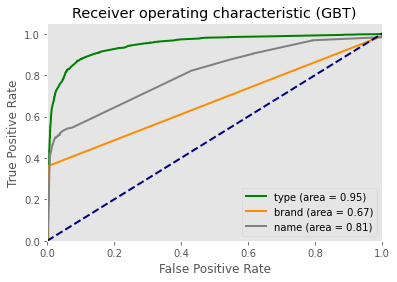

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# Receiver Operating Characteristic - ROC

fpr = {}
tpr = {}
roc_auc = {}
colors = {'type' : 'green', 'brand' : 'darkorange', 'name' : 'grey'}
for label in target_labels:
    fpr[label], tpr[label], _ = sklearn.metrics.roc_curve(y_true=list((df_test_result['Tag'] == label).astype(int)), 
                                  y_score=df_test_result[label].astype(float), pos_label=1)
    roc_auc[label] = auc(fpr[label], tpr[label])

plt.figure()
lw = 2
for label in target_labels:
    plt.plot(fpr[label], tpr[label], color=colors[label],
             lw=lw, label='%s (area = %0.2f)' % (label,roc_auc[label]))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (GBT)')
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [26]:
df_test_result.loc[df_test_result['TupleID'] == 7]

,TupleID,word,Tag,TagPred,type,brand,name,None
15,7,bàn,type,type,0.950744,0.000159,0.002111,0.028051
16,7,ủi,type,type,0.963565,0.000159,0.002111,0.039425
17,7,hơi,None,None,0.058950,0.000159,0.002111,0.928175
18,7,nước,None,None,0.092360,0.000159,0.003486,0.901268
19,7,đứng,None,None,0.054406,0.000159,0.013955,0.788919
20,7,bluestone,brand,brand,0.035751,0.999966,0.013955,0.389672
21,7,gsb-3915,name,name,0.022858,0.000159,0.925195,0.110657
22,7,-,None,None,0.007819,0.000159,0.013955,0.948480
23,7,tặng,None,None,0.009564,0.000159,0.013955,0.948689
24,7,máy,None,None,0.034134,0.000159,0.013955,0.952607
